In [52]:
import os
import zipfile
import numpy as np
import pandas as pd
import librosa
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [53]:
speech_path = r"C:\Desktop\iitr\mars_project\Audio_Speech_Actors_01-24"
song_path = r"C:\Desktop\iitr\mars_project\Audio_Song_Actors_01-24"


In [54]:
emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}


In [55]:
def get_file_df(base_path):
    filepaths, emotions = [], []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(".wav"):
                full_path = os.path.join(root, file)
                parts = file.split("-")
                emotion_id = parts[2]
                emotion = emotion_map.get(emotion_id)
                if emotion:
                    filepaths.append(full_path)
                    emotions.append(emotion)
    return pd.DataFrame({'filepath': filepaths, 'emotion': emotions})

df_speech = get_file_df(speech_path)
df_song = get_file_df(song_path)
df = pd.concat([df_speech, df_song], ignore_index=True)


In [56]:
print(df.head())
print(df.info())
print(df['emotion'].value_counts())

                                            filepath  emotion
0  C:\Desktop\iitr\mars_project\Audio_Speech_Acto...  neutral
1  C:\Desktop\iitr\mars_project\Audio_Speech_Acto...  neutral
2  C:\Desktop\iitr\mars_project\Audio_Speech_Acto...  neutral
3  C:\Desktop\iitr\mars_project\Audio_Speech_Acto...  neutral
4  C:\Desktop\iitr\mars_project\Audio_Speech_Acto...     calm
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  2452 non-null   object
 1   emotion   2452 non-null   object
dtypes: object(2)
memory usage: 38.4+ KB
None
emotion
calm         376
happy        376
sad          376
angry        376
fearful      376
disgust      192
surprised    192
neutral      188
Name: count, dtype: int64


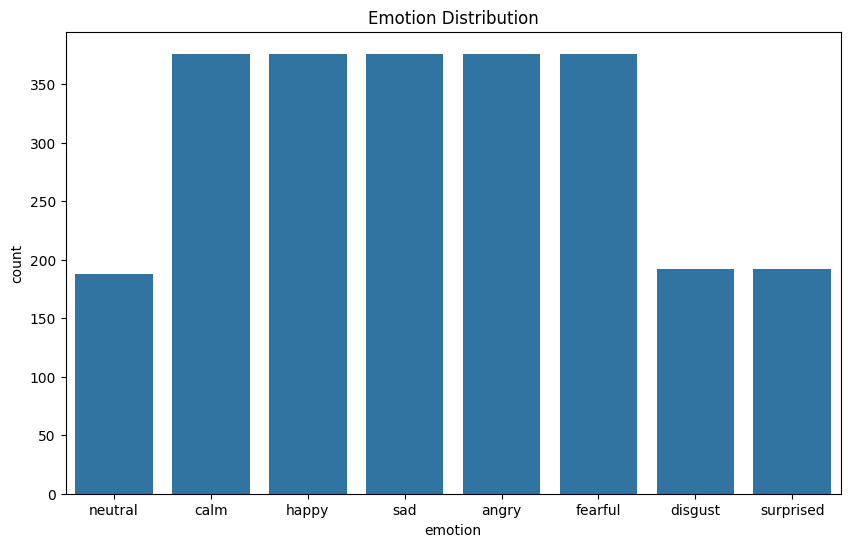

In [57]:
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=df)
plt.title("Emotion Distribution")
plt.show()

In [58]:
def extract_mfcc(path, max_pad_len=174):
    try:
        audio, sr = librosa.load(path, duration=3, offset=0.5)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        pad_width = max_pad_len - mfcc.shape[1]
        if pad_width > 0:
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]
        return mfcc
    except:
        return np.zeros((40, max_pad_len))

X = np.array([extract_mfcc(f) for f in df['filepath']])
y = df['emotion']

In [59]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2452 entries, 0 to 2451
Series name: emotion
Non-Null Count  Dtype 
--------------  ----- 
2452 non-null   object
dtypes: object(1)
memory usage: 19.3+ KB


In [60]:
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))


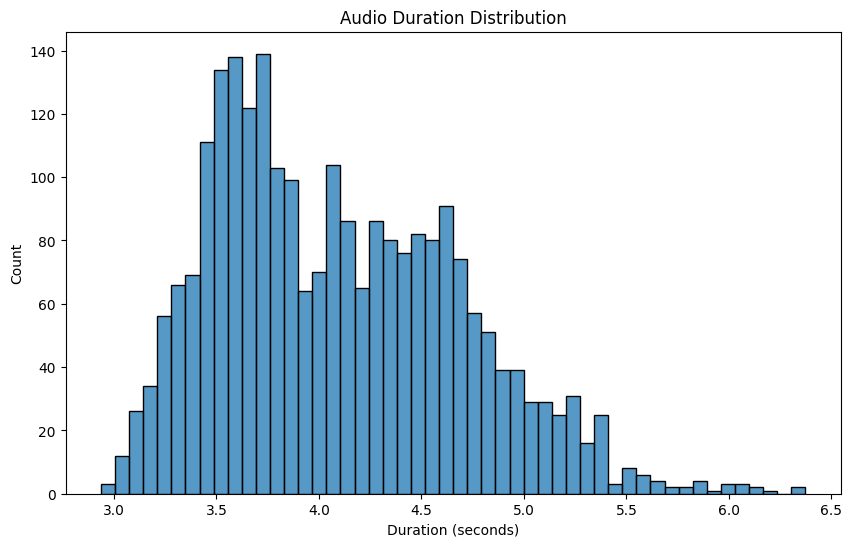

In [61]:
durations = []
for file in df['filepath']:
    audio, sr = librosa.load(file)
    durations.append(librosa.get_duration(y=audio, sr=sr))

df['duration'] = durations

plt.figure(figsize=(10,6))
sns.histplot(df['duration'], bins=50)
plt.title("Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.show()


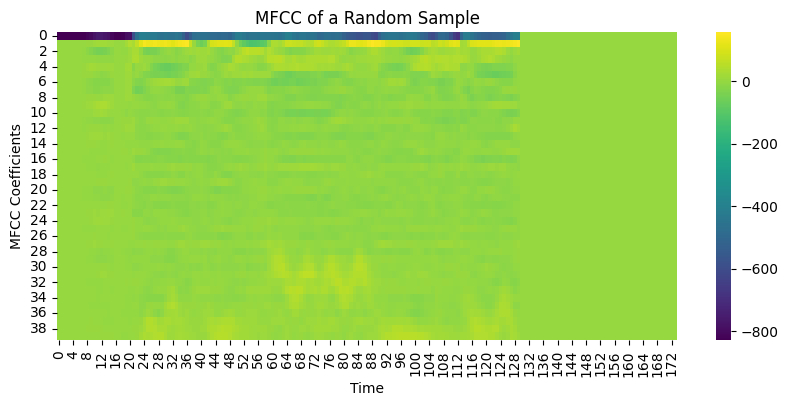

In [62]:
import random

sample_file = random.choice(df['filepath'])
mfcc_sample = extract_mfcc(sample_file)

plt.figure(figsize=(10, 4))
sns.heatmap(mfcc_sample, cmap='viridis')
plt.title('MFCC of a Random Sample')
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.show()


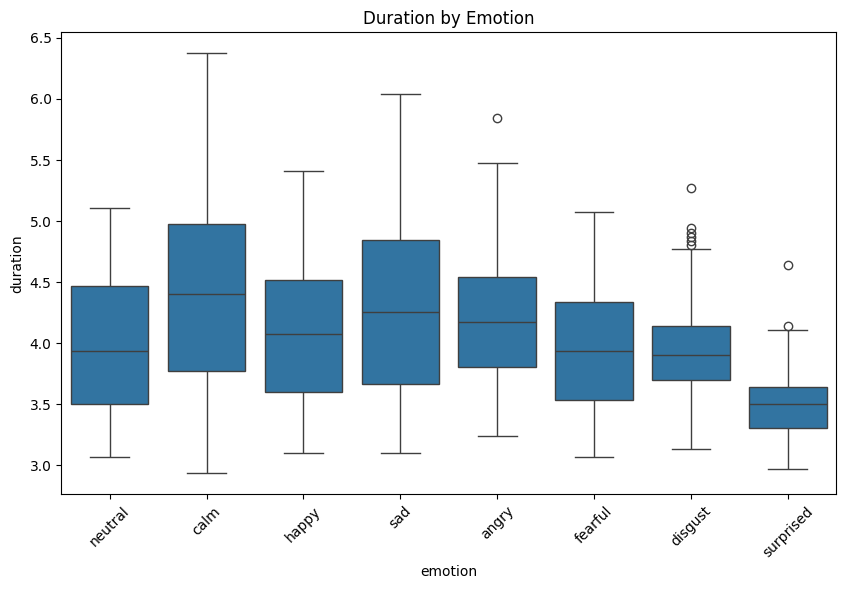

In [63]:
plt.figure(figsize=(10,6))
sns.boxplot(x='emotion', y='duration', data=df)
plt.title("Duration by Emotion")
plt.xticks(rotation=45)
plt.show()


In [64]:

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(40, 174, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history1 = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


c:\Users\abhay\tfenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 38, 172, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 17, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 21504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,752,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,772,488 (10.58 MB)

 Trainable params: 2,772,488 (10.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.1607 - loss: 15.4149 - val_accuracy: 0.3503 - val_loss: 1.7757
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.3726 - loss: 1.6577 - val_accuracy: 0.4603 - val_loss: 1.4482
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5606 - loss: 1.2636 - val_accuracy: 0.5621 - val_loss: 1.1991
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.6626 - loss: 0.9540 - val_accuracy: 0.6395 - val_loss: 1.0408
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7579 - loss: 0.6722 - val_accuracy: 0.6456 - val_loss: 1.0136
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8375 - loss: 0.4520 - val_accuracy: 0.6354 - val_loss: 1.0252
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8734 - loss: 0.3725 - val_accuracy: 0.6456 - val_loss: 1.1068
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9298 - loss: 0.2331 - val_accuracy: 0.6578 - 

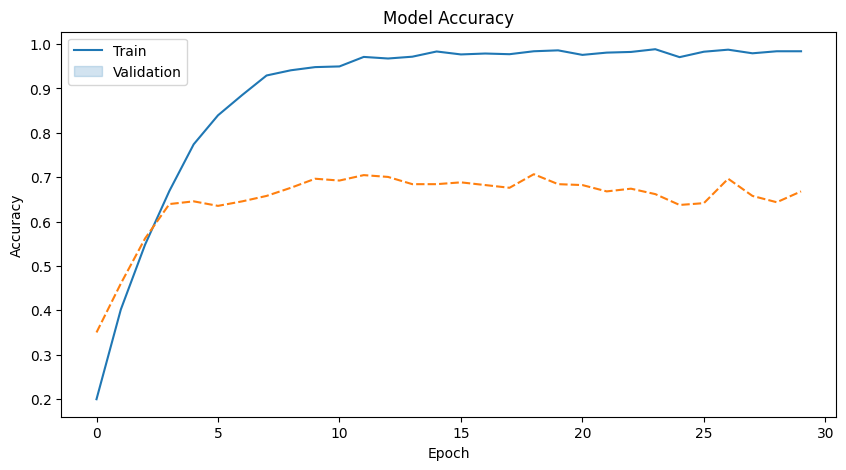

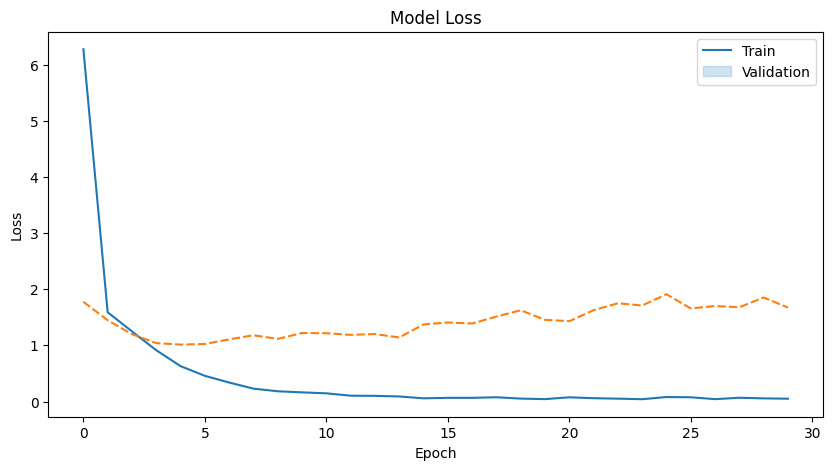

In [65]:

# Convert history to pandas DataFrame
history_df = pd.DataFrame(history1.history)

# Plot accuracy
plt.figure(figsize=(10, 5))
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()


In [66]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9895 - loss: 0.0365 - val_accuracy: 0.6904 - val_loss: 1.5960
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9841 - loss: 0.0467 - val_accuracy: 0.6721 - val_loss: 1.8212
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9829 - loss: 0.0477 - val_accuracy: 0.6843 - val_loss: 1.9565
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9779 - loss: 0.0667 - val_accuracy: 0.6802 - val_loss: 1.8046
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9857 - loss: 0.0471 - val_accuracy: 0.6884 - val_loss: 1.7838
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9868 - loss: 0.0414 - val_accuracy: 0.6680 - val_loss: 1.8360


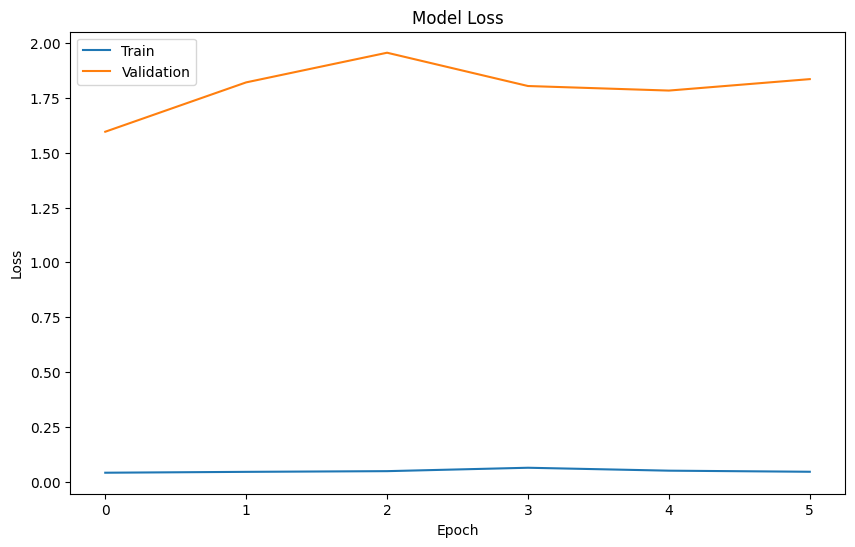

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


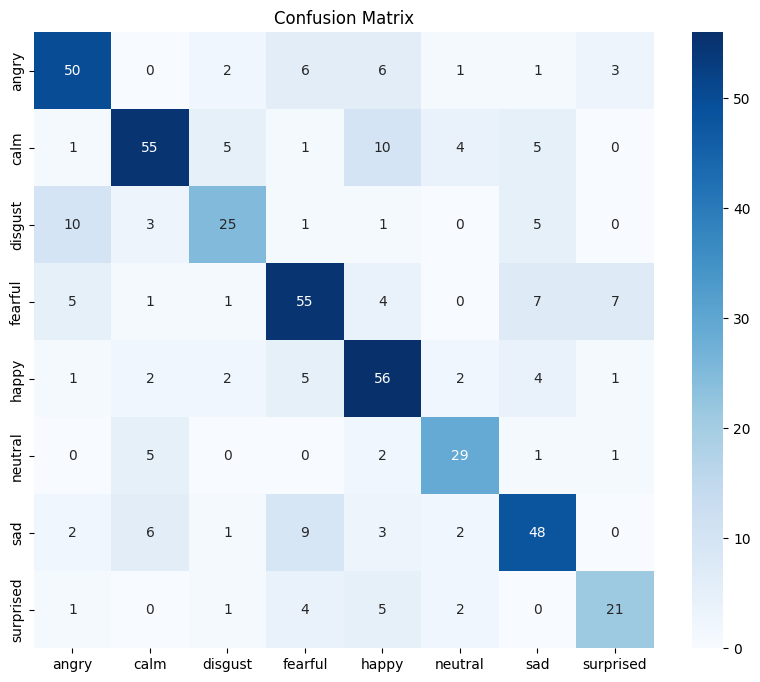

In [68]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

# Confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.show()


In [69]:
# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Extra metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
f2 = f1_score(y_true, y_pred, average='macro')
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (macro): {f1:.4f}")

Classification Report:

              precision    recall  f1-score   support

       angry       0.71      0.72      0.72        69
        calm       0.76      0.68      0.72        81
     disgust       0.68      0.56      0.61        45
     fearful       0.68      0.69      0.68        80
       happy       0.64      0.77      0.70        73
     neutral       0.72      0.76      0.74        38
         sad       0.68      0.68      0.68        71
   surprised       0.64      0.62      0.63        34

    accuracy                           0.69       491
   macro avg       0.69      0.68      0.68       491
weighted avg       0.69      0.69      0.69       491

Accuracy: 0.6904
F1 Score (macro): 0.6847


In [70]:
def predict_from_file(file_path):
    try:
        mfcc = extract_mfcc(file_path)
        mfcc = mfcc[np.newaxis, ..., np.newaxis]
        prediction = model.predict(mfcc)
        predicted_label = le.inverse_transform([np.argmax(prediction)])
        print(f"Predicted Emotion: {predicted_label[0]}")
    except Exception as e:
        print(f"Error: {e}")

In [71]:
user_file = input("Enter full path of .wav audio file: ").strip().replace('"','')
if os.path.exists(user_file):
    predict_from_file(user_file)
else:
    print("❌ Could not process the file. Please provide valid file path.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Predicted Emotion: neutral
